# Project 7: Implémentez un modèle de scoring

## 1. Import data and libraries

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

plt.style.use('fivethirtyeight')

In [2]:
app_test = pd.read_csv('data/application_test.csv')
app_train = pd.read_csv('data/application_train.csv')

In [3]:
print(f'train shape: {app_train.shape}')
print(f'test shape: {app_test.shape}')
print(f'train columns: {app_train.columns}')
app_train.head(5)

train shape: (307511, 122)
test shape: (48744, 121)
train columns: Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
print("The columns present in the train file and absent from the test file are:", list(set(app_train.columns.to_list()) - set(app_test.columns.to_list())) )

The columns present in the train file and absent from the test file are: ['TARGET']


## 2. Analysis
### 2.1 Target

In [5]:
target = app_train.groupby('TARGET')['SK_ID_CURR'].count().reset_index()
target

,TARGET,SK_ID_CURR
0,0,282686
1,1,24825


([<matplotlib.patches.Wedge at 0x1ddcd047250>,
 [Text(-1.0648123216659293, 0.27599768047650985, 'Credit payed'),
  Text(1.0648123152057372, -0.27599770540024077, 'Credit not payed')])

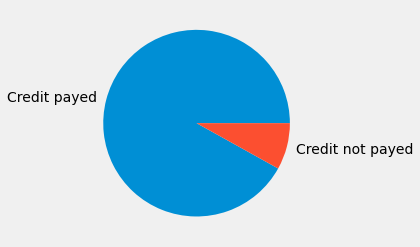

In [6]:
mylabels= ["Credit payed", "Credit not payed"]
plt.pie(target['SK_ID_CURR'], labels = mylabels)

### 2.2 Missing values

In [7]:
percent_missing = app_train.isnull().sum() * 100 / len(app_train)
percent_missing = percent_missing.reset_index().rename(columns={0:'perc_null'})

print(f"{len(percent_missing[percent_missing['perc_null'] > 0])} over {len(app_train.columns)} have missing values")
print(f"{len(percent_missing[percent_missing['perc_null'] > 50])} over {len(app_train.columns)} have more than 50% of null values")
percent_missing.sort_values('perc_null', ascending=False).head(20)

67 over 122 have missing values
41 over 122 have more than 50% of null values


,index,perc_null
76,COMMONAREA_MEDI,69.872297
48,COMMONAREA_AVG,69.872297
62,COMMONAREA_MODE,69.872297
70,NONLIVINGAPARTMENTS_MODE,69.432963
56,NONLIVINGAPARTMENTS_AVG,69.432963
84,NONLIVINGAPARTMENTS_MEDI,69.432963
86,FONDKAPREMONT_MODE,68.386172
68,LIVINGAPARTMENTS_MODE,68.354953
54,LIVINGAPARTMENTS_AVG,68.354953
82,LIVINGAPARTMENTS_MEDI,68.354953


In [8]:
columns_missing = percent_missing[percent_missing['perc_null'] > 50]['index'].to_list()
columns_missing.append('TARGET')

In [9]:
app_train[columns_missing].corr()['TARGET'].abs().sort_values()

NONLIVINGAPARTMENTS_MODE    0.001557
NONLIVINGAPARTMENTS_MEDI    0.002757
NONLIVINGAPARTMENTS_AVG     0.003176
LANDAREA_MODE               0.010174
LANDAREA_AVG                0.010885
LANDAREA_MEDI               0.011256
NONLIVINGAREA_MODE          0.012711
NONLIVINGAREA_MEDI          0.013337
NONLIVINGAREA_AVG           0.013578
COMMONAREA_MODE             0.016340
ENTRANCES_MODE              0.017387
COMMONAREA_AVG              0.018550
COMMONAREA_MEDI             0.018573
ENTRANCES_MEDI              0.019025
ENTRANCES_AVG               0.019172
BASEMENTAREA_MODE           0.019952
YEARS_BUILD_MODE            0.022068
BASEMENTAREA_MEDI           0.022081
YEARS_BUILD_AVG             0.022149
YEARS_BUILD_MEDI            0.022326
BASEMENTAREA_AVG            0.022746
LIVINGAPARTMENTS_MODE       0.023393
LIVINGAPARTMENTS_MEDI       0.024621
LIVINGAPARTMENTS_AVG        0.025031
APARTMENTS_MODE             0.027284
APARTMENTS_MEDI             0.029184
APARTMENTS_AVG              0.029498
L

In [10]:
columns_missing.remove('TARGET')
columns_missing.remove('EXT_SOURCE_1')

In [11]:
# detete column with more that 50% of missing values and a small correlation with the target
app_train.drop(columns=columns_missing, inplace=True)
app_test.drop(columns=columns_missing, inplace=True)

### 2.3 Numeric columns

In [12]:
app_train.dtypes.value_counts()

int64      41
float64    28
object     13
dtype: int64

In [13]:
pd.set_option('display.max_columns', None)
app_train.select_dtypes(['int64', 'float64']).describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,157504.000000,154491.000000,157504.000000,154491.000000,157504.000000,154491.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.977735,0.226282,0.977065,0.222315,0.977752,0.225897,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.059223,0.144641,0.064575,0.143709,0.059897,0.145067,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,0.03476,0.099144,0.016327,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,-24672.000000,-7197.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014568,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

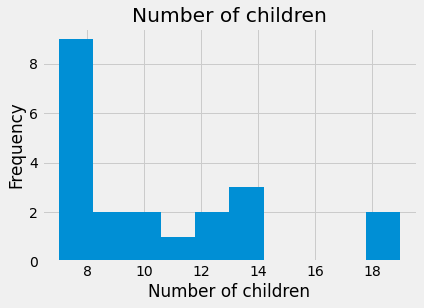

In [14]:
app_train[app_train['CNT_CHILDREN'] > 6]['CNT_CHILDREN'].plot.hist(title = 'Number of children');
plt.xlabel('Number of children');

In [15]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64


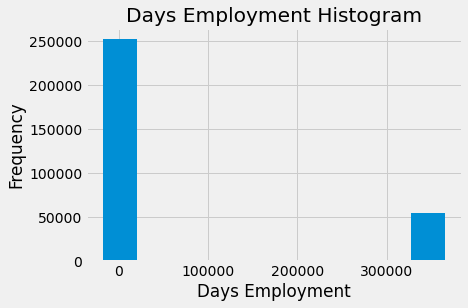

In [16]:
print((app_train['DAYS_EMPLOYED']).describe())

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
# enlever les donnees aberatens par rapport un age

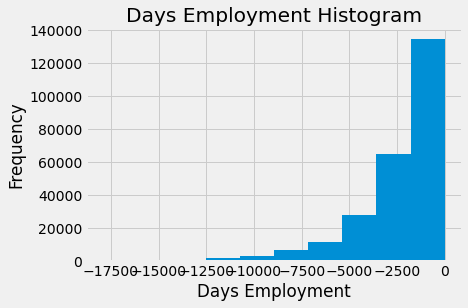

In [17]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [20]:
# no other aberant values
((app_train['DAYS_BIRTH'] / -365) - (app_train['DAYS_EMPLOYED'] / -365)).describe()

count    252137.000000
mean         33.931408
std           9.820123
min          17.928767
25%          25.835616
50%          32.745205
75%          40.958904
max          68.210959
dtype: float64

In [116]:
app_train.select_dtypes('int64').groupby('TARGET').describe()

SK_ID_CURR                                                     \
            count           mean            std       min        25%   
TARGET                                                                 
0        282682.0  278245.842707  102825.730701  100003.0  189104.25   
1         24825.0  277449.167936  102383.123458  100002.0  189555.00   

                                      CNT_CHILDREN                           \
             50%        75%       max        count      mean       std  min   
TARGET                                                                        
0       278363.5  367242.75  456255.0     282682.0  0.412941  0.718840  0.0   
1       276291.0  366050.00  456254.0      24825.0  0.463807  0.756903  0.0   

                            NAME_EDUCATION_TYPE                                \
        25%  50%  75%   max               count      mean       std  min  25%   
TARGET                                                                          
0       0.0  0.0  1.0  19.0            282682.0  1.306864  0.553804  0.0  1.0   
1       0.0  0.0  1.0  11.0             24825.0  1.215307  0.523004  0.0  1.0   

                      FLAG_MOBIL                                               \
        50%  75%  max      count      mean       std  min  25%  50%  75%  max   
TARGET                                                                          
0       1.0  2.0  4.0   282682.0  0.999996  0.001881  0.0  1.0  1.0  1.0  1.0   
1       1.0  1.0  4.0    24825.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   

       FLAG_EMP_PHONE                                               \
                count      mean       std  min  25%  50%  75%  max   
TARGET                                                               
0            282682.0  0.814650  0.388582  0.0  1.0  1.0  1.0  1.0   
1             24825.0  0.879517  0.325532  0.0  1.0  1.0  1.0  1.0   

       FLAG_WORK_PHONE                                               \
                 count      mean       std  min  25%  50%  75%  max   
TARGET                                                                
0             282682.0  0.195980  0.396954  0.0  0.0  0.0  0.0  1.0   
1              24825.0  0.237825  0.425760  0.0  0.0  0.0  0.0  1.0   

       FLAG_CONT_MOBILE                                               \
                  count      mean       std  min  25%  50%  75%  max   
TARGET                                                                 
0              282682.0  0.998129  0.043219  0.0  1.0  1.0  1.0  1.0   
1               24825.0  0.998187  0.042538  0.0  1.0  1.0  1.0  1.0   

       FLAG_PHONE                                              FLAG_EMAIL  \
            count      mean       std  min  25%  50%  75%  max      count   
TARGET                                                                      
0        282682.0  0.284228  0.451047  0.0  0.0  0.0  1.0  1.0   282682.0   
1         24825.0  0.244955  0.430069  0.0  0.0  0.0  0.0  1.0    24825.0   

                                                    REGION_RATING_CLIENT  \
            mean       std  min  25%  50%  75%  max                count   
TARGET                                                                     
0       0.056841  0.231539  0.0  0.0  0.0  0.0  1.0             282682.0   
1       0.055347  0.228662  0.0  0.0  0.0  0.0  1.0              24825.0   

                                                     \
            mean       std  min  25%  50%  75%  max   
TARGET                                                
0       2.043575  0.508423  1.0  2.0  2.0  2.0  3.0   
1       2.153635  0.505052  1.0  2.0  2.0  2.0  3.0   

       REGION_RATING_CLIENT_W_CITY                                          \
                             count      mean       std  min  25%  50%  75%   
TARGET                                                                       
0                         282682.0  2.022446  0.501971  1.0  2.0  2.0  2.0   
1              

In [21]:
app_train['DAYS_BIRTH'] = app_train['DAYS_BIRTH'] / -365
app_train['DAYS_ID_PUBLISH'] = app_train['DAYS_ID_PUBLISH'] / -365

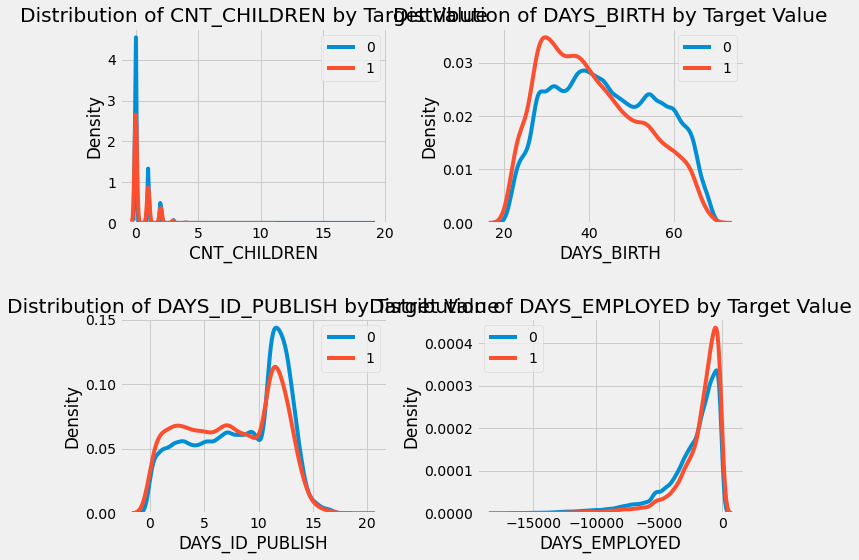

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize = (10, 8))
# iterate through the sources
for i, source in enumerate(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']):
    
    # create a new subplot for each source
    fig = plt.subplot(2, 2, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source])
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source])
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
    fig.legend(labels=['0','1'])

    
plt.tight_layout(h_pad = 2.5)
    

In [ ]:
#technique de travailler une variable numerique 
# pandas cut qauntile pour couper 
featureengineer 

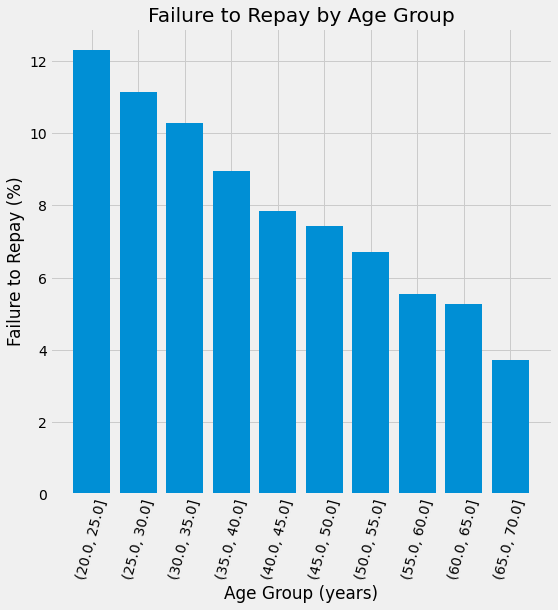

In [26]:
app_train['AGE_BIN'] = pd.cut(app_train['DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))
plt.figure(figsize = (8, 8))

df_plot = app_train.groupby('AGE_BIN')['TARGET'].mean() * 100
df_plot = df_plot.reset_index()
# Graph the age bins and the average of the target as a bar plot
plt.bar(df_plot['AGE_BIN'].astype(str), df_plot['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

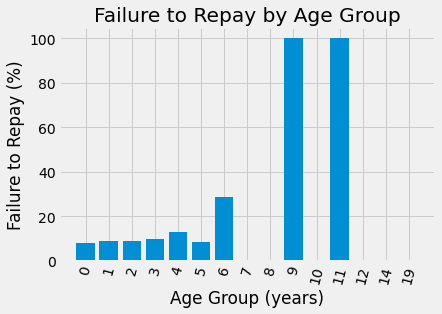

In [27]:
df_plot = app_train.groupby('CNT_CHILDREN')['TARGET'].mean() * 100
df_plot = df_plot.reset_index()
# Graph the age bins and the average of the target as a bar plot
plt.bar(df_plot['CNT_CHILDREN'].astype(str), df_plot['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Number of children Group');

In [28]:
#ratio
corr = app_train[['CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'TARGET']].corr()
corr.style.background_gradient(cmap='coolwarm')

,CNT_CHILDREN,CNT_FAM_MEMBERS,TARGET
CNT_CHILDREN,1.000000,0.879161,0.019187
CNT_FAM_MEMBERS,0.879161,1.000000,0.009308
TARGET,0.019187,0.009308,1.000000


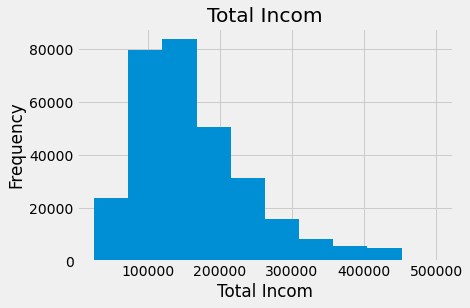

In [118]:

app_train[app_train['AMT_INCOME_TOTAL'] < 500000]['AMT_INCOME_TOTAL'].plot.hist(title = 'Total Incom');
plt.xlabel('Total Incom');

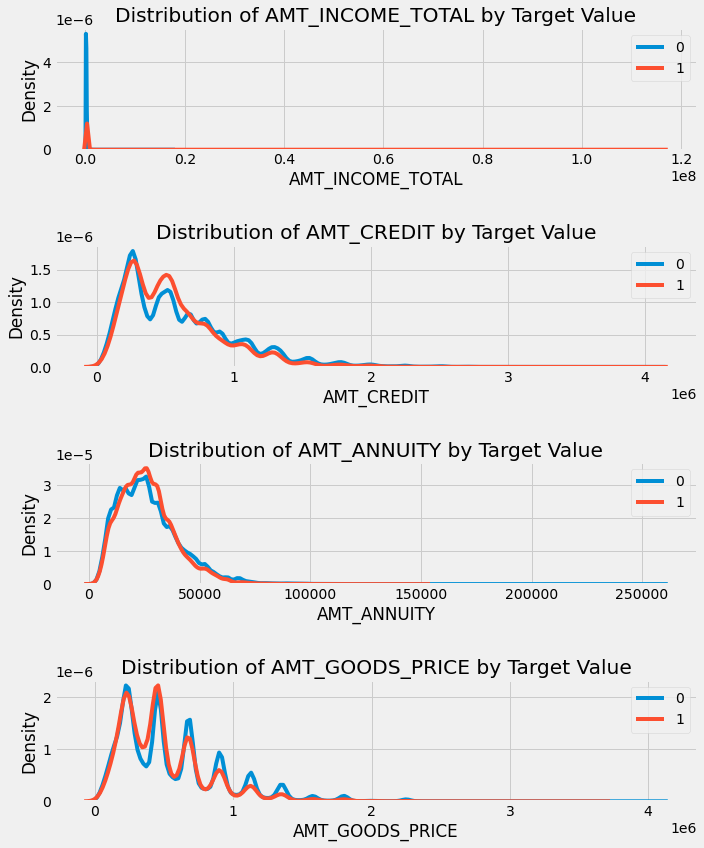

In [30]:
plt.figure(figsize = (10, 12))
# iterate through the sources
for i, source in enumerate(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']):
    
    # create a new subplot for each source
    fig = plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source])
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source])
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
    fig.legend(labels=['0','1'])

    
plt.tight_layout(h_pad = 2.5)

In [31]:
amt_columns = [col for col in app_train.columns if 'AMT' in col]
amt_columns.append('TARGET')
corr = app_train[amt_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
AMT_INCOME_TOTAL,1.000000,0.156870,0.191657,0.159610,0.000709,0.002944,0.002387,0.024700,0.004859,0.011690,-0.003982
AMT_CREDIT,0.156870,1.000000,0.770138,0.986968,-0.003906,0.004238,-0.001275,0.054451,0.015925,-0.048448,-0.030369
AMT_ANNUITY,0.191657,0.770138,1.000000,0.775109,0.003861,0.002185,0.013881,0.039148,0.010124,-0.011320,-0.012817
AMT_GOODS_PRICE,0.159610,0.986968,0.775109,1.000000,-0.003237,0.004677,-0.001007,0.056422,0.016432,-0.050998,-0.039645
AMT_REQ_CREDIT_BUREAU_HOUR,0.000709,-0.003906,0.003861,-0.003237,1.000000,0.230374,0.004706,-0.000018,-0.002716,-0.004597,0.000930
AMT_REQ_CREDIT_BUREAU_DAY,0.002944,0.004238,0.002185,0.004677,0.230374,1.000000,0.217412,-0.005258,-0.004416,-0.003355,0.002704
AMT_REQ_CREDIT_BUREAU_WEEK,0.002387,-0.001275,0.013881,-0.001007,0.004706,0.217412,1.000000,-0.014096,-0.015115,0.018917,0.000788
AMT_REQ_CREDIT_BUREAU_MON,0.024700,0.054451,0.039148,0.056422,-0.000018,-0.005258,-0.014096,1.000000,-0.007789,-0.004975,-0.012462
AMT_REQ_CREDIT_BUREAU_QRT,0.004859,0.015925,0.010124,0.016432,-0.002716,-0.004416,-0.015115,-0.007789,1.000000,0.076208,-0.002022
AMT_REQ_CREDIT_BUREAU_YEAR,0.011690,-0.048448,-0.011320,-0.050998,-0.004597,-0.003355,0.018917,-0.004975,0.076208,1.000000,0.019930


In [32]:
flag_columns = [col for col in app_train.columns if 'FLAG' in col]
flag_columns.append('TARGET')
corr = app_train[flag_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
FLAG_MOBIL,1.000000,-0.000845,0.000900,-0.000078,0.001128,0.000442,0.000012,0.002822,0.000016,0.000223,0.000560,0.000025,-0.006059,0.000113,0.000009,0.000113,0.000005,0.000107,0.000098,0.000063,0.000181,0.000029,-0.019919,0.000044,0.000041,0.000033,0.000534
FLAG_EMP_PHONE,-0.000845,1.000000,0.233801,-0.012819,-0.016131,0.062542,0.003047,0.248534,-0.000467,0.019778,-0.597732,0.001605,0.122043,0.023878,0.000463,0.029373,0.001195,0.025878,0.023559,0.014364,0.043008,0.007136,0.040548,0.010049,0.010183,0.008579,0.045982
FLAG_WORK_PHONE,0.000900,0.233801,1.000000,0.021580,0.293105,-0.011520,-0.001993,0.060342,-0.004500,0.036847,-0.138345,0.001902,0.021464,0.008252,0.002737,0.123500,-0.001273,0.001769,-0.002712,0.007689,0.005692,0.001322,0.032049,0.011854,0.001771,0.001541,0.028524
FLAG_CONT_MOBILE,-0.000078,-0.012819,0.021580,1.000000,0.006257,-0.005356,0.000281,0.006235,0.000390,0.005357,0.009981,-0.004841,-0.022400,-0.008180,0.000206,0.002710,0.000110,-0.064800,-0.072839,-0.013667,-0.030625,-0.013136,-0.043068,-0.005123,0.000974,-0.015677,0.000370
FLAG_PHONE,0.001128,-0.016131,0.293105,0.006257,1.000000,0.014657,-0.000728,-0.008020,0.003990,0.075455,0.009836,0.013276,0.004778,0.012923,0.004598,0.003231,-0.001595,0.006997,0.010321,0.008001,0.010354,0.004410,0.004055,0.009660,0.000692,0.000020,-0.023806
FLAG_EMAIL,0.000442,0.062542,-0.011520,-0.005356,0.014657,1.000000,0.002730,0.012015,0.002467,0.000734,-0.042660,0.001678,0.030474,0.009490,0.001777,-0.003656,-0.000625,-0.003436,0.001502,-0.003276,-0.012644,-0.001422,-0.008110,-0.002525,-0.001778,-0.000647,-0.001758
FLAG_DOCUMENT_2,0.000012,0.003047,-0.001993,0.000281,-0.000728,0.002730,1.000000,-0.010174,-0.000059,-0.000805,-0.002020,-0.000090,-0.001935,-0.000407,-0.000031,-0.000407,-0.000017,-0.000387,-0.000353,-0.000226,-0.000651,-0.000106,-0.000589,-0.000159,-0.000146,-0.000119,0.005417
FLAG_DOCUMENT_3,0.002822,0.248534,0.060342,0.006235,-0.008020,0.012015,-0.010174,1.000000,-0.014110,-0.193850,-0.486238,-0.021677,-0.465730,-0.097859,-0.007466,-0.093242,-0.001180,-0.020274,0.002099,0.000592,0.033418,0.002536,0.007976,0.009423,0.007396,-0.025510,0.044346
FLAG_DOCUMENT_4,0.000016,-0.000467,-0.004500,0.000390,0.003990,0.002467,-0.000059,-0.014110,1.000000,-0.001117,-0.002802,-0.000125,-0.002684,-0.000564,-0.000043,-0.000565,-0.000023,-0.000536,-0.000489,-0.000314,-0.000903,-0.000147,-0.000816,-0.000220,-0.000203,-0.000165,-0.002672
FLAG_DOCUMENT_5,0.000223,0.019778,0.036847,0.005357,0.075455,0.000734,-0.000805,-0.193850,-0.001117,1.000000,-0.038495,-0.001716,-0.036871,-0.007747,-0.000591,-0.007764,-0.000316,-0.007368,-0.006723,-0.004311,-0.012137,-0.002023,-0.010622,-0.003023,-0.002791,0.000645,-0.000316


In [33]:
ext_columns = [col for col in app_train.columns if 'EXT' in col]
ext_columns.append('TARGET')
corr = app_train[ext_columns].corr()
corr.style.background_gradient(cmap='coolwarm')

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.000000,0.213982,0.186846,-0.155317
EXT_SOURCE_2,0.213982,1.000000,0.109167,-0.160472
EXT_SOURCE_3,0.186846,0.109167,1.000000,-0.178919
TARGET,-0.155317,-0.160472,-0.178919,1.000000


##### object

In [34]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
EMERGENCYSTATE_MODE            2
dtype: int64

In [35]:
app_train.select_dtypes('object').columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'EMERGENCYSTATE_MODE'],
      dtype='object')

In [36]:
app_train = app_train[app_train['CODE_GENDER']!='XNA']

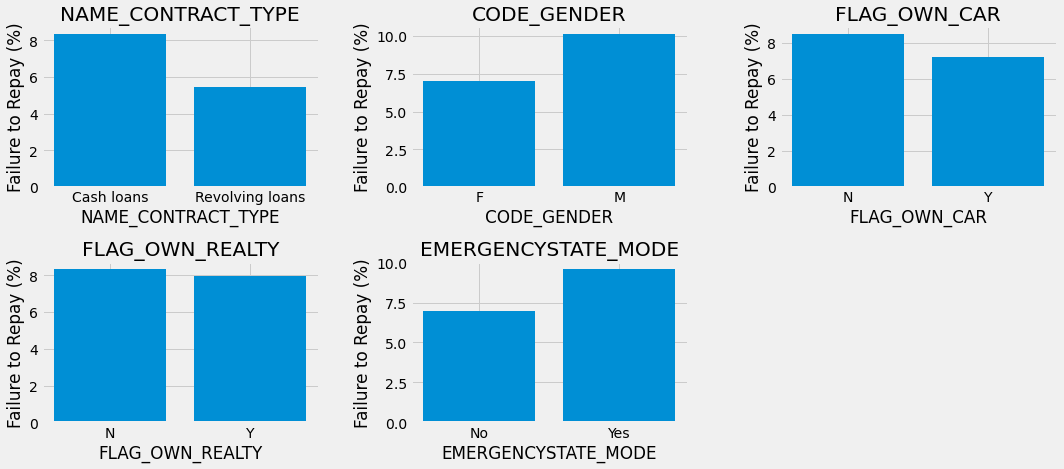

In [37]:
plt.figure(figsize = (15,16))
for i, source in enumerate(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']):
    
    # create a new subplot for each source
    fig = plt.subplot(5, 3, i + 1)
    df_plot = app_train.groupby(source)['TARGET'].mean() * 100
    df_plot = df_plot.reset_index()
    # Graph the age bins and the average of the target as a bar plot
    plt.bar(df_plot[source].astype(str), df_plot['TARGET'])

    # Plot labeling
    #plt.xticks(rotation = 20); 
    plt.xlabel(source); 
    plt.ylabel('Failure to Repay (%)')
    plt.title(f'{source}');
plt.tight_layout(h_pad = 2.5)
plt.tight_layout(w_pad = 2.5)

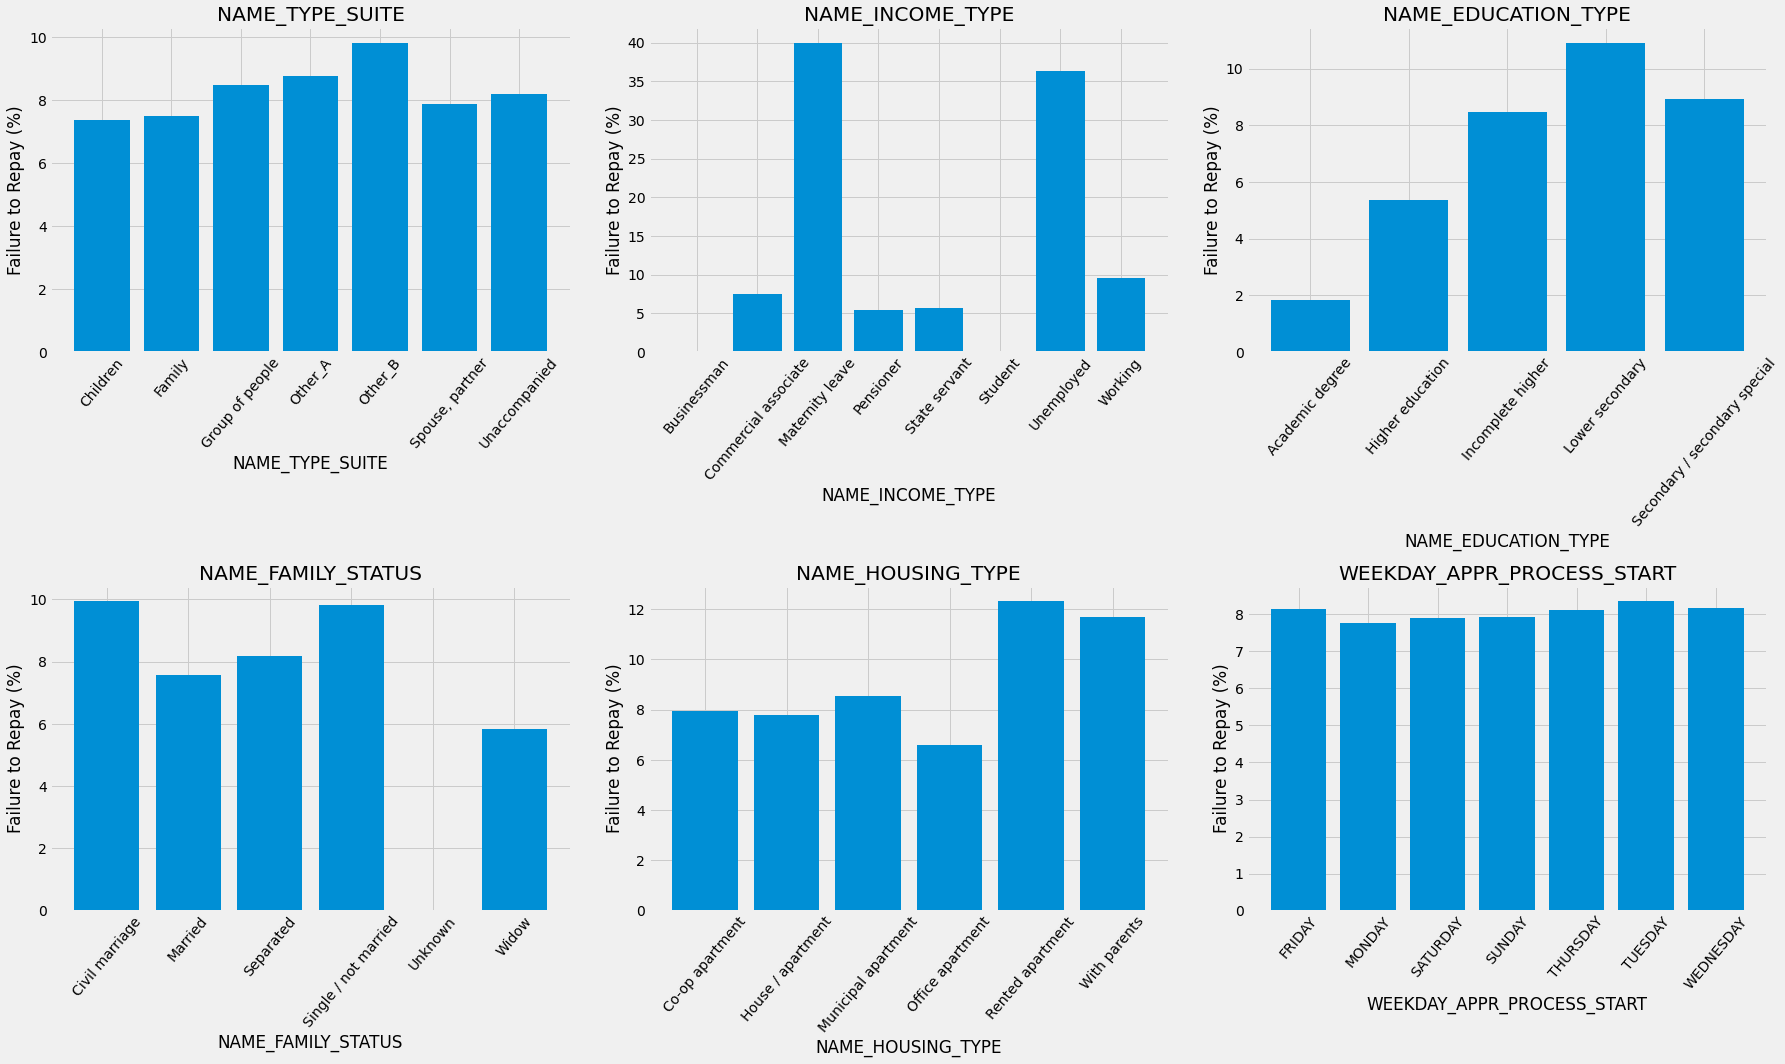

In [38]:
plt.figure(figsize = (25,15))
for i, source in enumerate(['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START']):
    
    # create a new subplot for each source
    fig = plt.subplot(2, 3, i + 1)
    df_plot = app_train.groupby(source)['TARGET'].mean() * 100
    df_plot = df_plot.reset_index()
    # Graph the age bins and the average of the target as a bar plot
    plt.bar(df_plot[source].astype(str), df_plot['TARGET'])

    # Plot labeling
    plt.xticks(rotation =50); 
    plt.xlabel(source); 
    plt.ylabel('Failure to Repay (%)')
    plt.title(f'{source}');
plt.tight_layout(h_pad = 2.5)
plt.tight_layout(w_pad = 2.5)

In [39]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

4 columns were label encoded.


In [40]:
app_train['NAME_EDUCATION_TYPE'].unique()

array(['Secondary / secondary special', 'Higher education',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [41]:
print(app_train['NAME_EDUCATION_TYPE'].unique())
education  = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Higher education': 2,
    'Incomplete higher' : 3,
    'Academic degree': 4
}

app_train['NAME_EDUCATION_TYPE'] = app_train['NAME_EDUCATION_TYPE'].apply(lambda x: education[x])
app_test['NAME_EDUCATION_TYPE'] = app_test['NAME_EDUCATION_TYPE'].apply(lambda x: education[x])

print(app_train['NAME_EDUCATION_TYPE'].unique())

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
[1 2 3 0 4]


In [42]:
app_train.shape

(307507, 83)

In [43]:
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print(f'Training Features shape: {app_train.shape}')
print(f'Testing Features shape: {app_test.shape}')

Training Features shape: (307507, 196)
Testing Features shape: (48744, 183)


In [44]:
target = app_train['TARGET']
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = target
print(f'Training Features shape: {app_train.shape}')
print(f'Testing Features shape: {app_test.shape}')

Training Features shape: (307507, 184)
Testing Features shape: (48744, 183)


In [45]:
bureau_balance = pd.read_csv('data/bureau_balance.csv')
bureau = pd.read_csv('data/bureau.csv')

In [46]:
print(bureau.columns)

Index(['SK_ID_CURR', 'SK_ID_BUREAU', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'CREDIT_TYPE', 'DAYS_CREDIT_UPDATE',
       'AMT_ANNUITY'],
      dtype='object')


In [47]:
bureau = pd.concat([bureau, pd.get_dummies(bureau['CREDIT_ACTIVE'])], axis=1)
credit_active = bureau.groupby(['SK_ID_CURR'])[['Active', 'Bad debt', 'Closed', 'Sold']].sum().reset_index()
credit_active.head(3)

,SK_ID_CURR,Active,Bad debt,Closed,Sold
0,100001,3,0,4,0
1,100002,2,0,6,0
2,100003,1,0,3,0


In [48]:
credit_sum = bureau.groupby(['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index()
credit_sum.head(3)

,SK_ID_CURR,AMT_CREDIT_SUM
0,100001,1453365.000
1,100002,865055.565
2,100003,1017400.500


In [49]:
app_train = app_train.merge(credit_active, on='SK_ID_CURR', how='left')
app_train = app_train.merge(credit_sum, on='SK_ID_CURR', how='left')
app_test = app_test.merge(credit_active, on='SK_ID_CURR', how='left')
app_test = app_test.merge(credit_sum, on='SK_ID_CURR', how='left')

In [50]:
app_train['DAYS_BIRTH']

0         25.920548
1         45.931507
2         52.180822
3         52.068493
4         54.608219
            ...    
307502    25.553425
307503    56.917808
307504    41.002740
307505    32.769863
307506    46.180822
Name: DAYS_BIRTH, Length: 307507, dtype: float64

In [51]:
app_train['DAYS_EMPLOYED']

0         -637.0
1        -1188.0
2         -225.0
3        -3039.0
4        -3038.0
           ...  
307502    -236.0
307503       NaN
307504   -7921.0
307505   -4786.0
307506   -1262.0
Name: DAYS_EMPLOYED, Length: 307507, dtype: float64

In [52]:
app_train['DAYS_BIRTH'] = app_train['DAYS_BIRTH'] * -365
app_train['DAYS_EMPLOYED_PERC'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']
app_train['DAYS_EMPLOYED_PERC'].describe()

count    252133.000000
mean          0.156860
std           0.133548
min          -0.000000
25%           0.056098
50%           0.118733
75%           0.219167
max           0.728811
Name: DAYS_EMPLOYED_PERC, dtype: float64

In [53]:
app_train[['DAYS_BIRTH', 'DAYS_EMPLOYED_PERC']].corr()

,DAYS_BIRTH,DAYS_EMPLOYED_PERC
DAYS_BIRTH,1.000000,-0.137912
DAYS_EMPLOYED_PERC,-0.137912,1.000000


count    307495.000000
mean          0.180931
std           0.094574
min           0.000224
25%           0.114783
50%           0.162833
75%           0.229067
max           1.875965
Name: ANNUITY_INCOME_PERC, dtype: float64


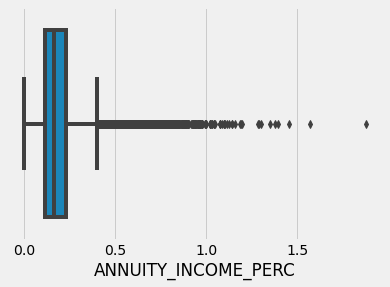

In [54]:
app_train['ANNUITY_INCOME_PERC'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
print(app_train['ANNUITY_INCOME_PERC'].describe())
sns.boxplot(x=app_train['ANNUITY_INCOME_PERC']);

In [55]:
print(app_train[app_train['ANNUITY_INCOME_PERC'] >= 1]['TARGET'].mean())
print(app_train[app_train['ANNUITY_INCOME_PERC'] < 1]['TARGET'].mean())

0.14705882352941177
0.08072568553410026


In [56]:
app_train['PAYMENT_RATE'] = app_train['AMT_CREDIT'] / app_train['AMT_ANNUITY']
app_train['PAYMENT_RATE'].describe()

count    307495.000000
mean          0.053695
std           0.022481
min           0.022073
25%           0.036900
50%           0.050000
75%           0.064043
max           0.124430
Name: PAYMENT_RATE, dtype: float64

count    307229.000000
mean          0.900688
std           0.096619
min           0.166667
25%           0.834725
50%           0.893815
75%           1.000000
max           6.666667
Name: PERCENT_GOODS_NOT_PAYED, dtype: float64


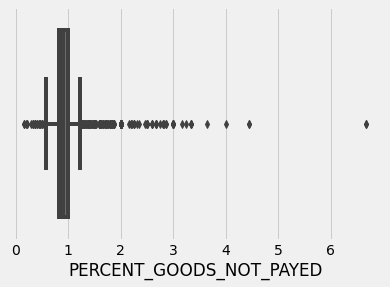

In [57]:
app_train['PERCENT_GOODS_NOT_PAYED'] = app_train['AMT_CREDIT'] / app_train['AMT_GOODS_PRICE'] 
print(app_train['PERCENT_GOODS_NOT_PAYED'].describe())
sns.boxplot(x=app_train['PERCENT_GOODS_NOT_PAYED']);

In [58]:
print(app_train[app_train['PERCENT_GOODS_NOT_PAYED'] >= 1]['TARGET'].mean())
print(app_train[app_train['PERCENT_GOODS_NOT_PAYED'] < 1]['TARGET'].mean())

0.06746628068849164
0.08797544777621252


In [59]:
app_train.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'TARGET', 'Active', 'Bad debt', 'Closed', 'Sold', 'AMT_CREDIT_SUM',
       'DAYS_EMPLOYED_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE',
       'PERCENT_GOODS_NOT_PAYED'],
      dtype='object', length=193)

In [60]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
app_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307507 entries, 0 to 307506
Data columns (total 193 columns):
 #    Column                                    Non-Null Count   Dtype  
---   ------                                    --------------   -----  
 0    SK_ID_CURR                                307507 non-null  int64  
 1    NAME_CONTRACT_TYPE                        307507 non-null  int32  
 2    CODE_GENDER                               307507 non-null  int32  
 3    FLAG_OWN_CAR                              307507 non-null  int32  
 4    FLAG_OWN_REALTY                           307507 non-null  int32  
 5    CNT_CHILDREN                              307507 non-null  int64  
 6    AMT_INCOME_TOTAL                          307507 non-null  float64
 7    AMT_CREDIT                                307507 non-null  float64
 8    AMT_ANNUITY                               307495 non-null  float64
 9    AMT_GOODS_PRICE                           307229 non-null  float64
 10   NAME_E

In [61]:
app_train.fillna(app_train.mean(), inplace=True)

In [34]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.
    
    Parameters
    --------
        df (dataframe): 
            the child dataframe to calculate the statistics on
        parent_var (string): 
            the parent variable used for grouping and aggregating
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated by the `parent_var` for 
            all numeric columns. Each observation of the parent variable will have 
            one row in the dataframe with the parent variable as the index. 
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed. 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['mean'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg

In [35]:
def agg_categorical(df, parent_var, df_name):
    """
    Aggregates the categorical features in a child dataframe
    for each observation of the parent variable.
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    parent_var : string
        The variable by which to group and aggregate the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with aggregated statistics for each observation of the parent_var
        The columns are also renamed and columns with duplicate values are removed.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('category'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [37]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)

        
    return df

In [38]:
previous = pd.read_csv('data/previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

Original Memory Usage: 0.49 gb.
New Memory Usage: 0.18 gb.


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,True,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,True,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,True,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,True,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 18)


,previous_DAYS_DECISION_mean,previous_DAYS_FIRST_DUE_mean,previous_DAYS_LAST_DUE_mean,previous_DAYS_TERMINATION_mean,previous_DAYS_LAST_DUE_1ST_VERSION_mean,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_RATE_DOWN_PAYMENT_mean,previous_CNT_PAYMENT_mean,previous_HOUR_APPR_PROCESS_START_mean,previous_SELLERPLACE_AREA_mean,previous_AMT_DOWN_PAYMENT_mean,previous_AMT_ANNUITY_mean,previous_AMT_CREDIT_mean,previous_AMT_APPLICATION_mean,previous_AMT_GOODS_PRICE_mean,previous_DAYS_FIRST_DRAWING_mean,previous_RATE_INTEREST_PRIMARY_mean,previous_RATE_INTEREST_PRIVILEGED_mean
SK_ID_CURR,,,,,,,,,,,,,,,,,,
100001,-1740.0,-1709.000000,-1619.000000,-1612.000000,-1499.000000,0.000000,0.104326,8.0,13.000000,23.0,2520.0,3951.000000,23787.00,24835.50,24835.5,365243.0,NaN,NaN
100002,-606.0,-565.000000,-25.000000,-17.000000,125.000000,0.000000,0.000000,24.0,9.000000,500.0,0.0,9251.775391,179055.00,179055.00,179055.0,365243.0,NaN,NaN
100003,-1305.0,-1274.333374,-1054.333374,-1047.333374,-1004.333313,0.666667,0.050030,10.0,14.666667,533.0,3442.5,56553.988281,484191.00,435436.50,435436.5,365243.0,NaN,NaN
100004,-815.0,-784.000000,-724.000000,-714.000000,-694.000000,0.000000,0.212008,4.0,5.000000,30.0,4860.0,5357.250000,20106.00,24282.00,24282.0,365243.0,NaN,NaN
100005,-536.0,-706.000000,-466.000000,-460.000000,-376.000000,0.000000,0.108964,12.0,10.500000,18.0,4464.0,4813.200195,20076.75,22308.75,44617.5,365243.0,NaN,NaN


In [40]:
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 142)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_GOODS_CATEGORY_Education_mean,previous_NAME_GOODS_CATEGORY_Additional Service_mean,previous_NAME_CASH_LOAN_PURPOSE_Gasification / water supply_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a garage_mean,previous_NAME_GOODS_CATEGORY_Insurance_mean,previous_NAME_CASH_LOAN_PURPOSE_Business development_mean,previous_NAME_GOODS_CATEGORY_Fitness_mean,previous_NAME_CASH_LOAN_PURPOSE_Wedding / gift / holiday_mean,previous_NAME_SELLER_INDUSTRY_MLM partners_mean,previous_NAME_GOODS_CATEGORY_Direct Sales_mean,previous_NAME_CASH_LOAN_PURPOSE_Purchase of electronic equipment_mean,previous_NAME_CASH_LOAN_PURPOSE_Journey_mean,previous_NAME_CASH_LOAN_PURPOSE_Furniture_mean,previous_NAME_GOODS_CATEGORY_Weapon_mean,previous_CODE_REJECT_REASON_SYSTEM_mean,previous_NAME_CONTRACT_TYPE_XNA_mean,previous_NAME_CASH_LOAN_PURPOSE_Building a house or an annex_mean,previous_NAME_GOODS_CATEGORY_Medicine_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a holiday home / land_mean,previous_NAME_GOODS_CATEGORY_Sport and Leisure_mean,previous_CHANNEL_TYPE_Car dealer_mean,previous_NAME_PORTFOLIO_Cars_mean,previous_NAME_CASH_LOAN_PURPOSE_Car repairs_mean,previous_NAME_TYPE_SUITE_Group of people_mean,previous_NAME_SELLER_INDUSTRY_Jewelry_mean,previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean,previous_NAME_PAYMENT_TYPE_Non-cash from your account_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a home_mean,previous_NAME_SELLER_INDUSTRY_Tourism_mean,previous_NAME_GOODS_CATEGORY_Tourism_mean,previous_CODE_REJECT_REASON_XNA_mean,previous_NAME_CASH_LOAN_PURPOSE_Medicine_mean,previous_NAME_GOODS_CATEGORY_Office Appliances_mean,previous_NAME_GOODS_CATEGORY_Jewelry_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a new car_mean,previous_NAME_GOODS_CATEGORY_Other_mean,previous_NAME_CASH_LOAN_PURPOSE_Urgent needs_mean,previous_NAME_GOODS_CATEGORY_Auto Accessories_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_N_mean,previous_CODE_REJECT_REASON_VERIF_mean,previous_CODE_REJECT_REASON_SCOFR_mean,previous_NAME_GOODS_CATEGORY_Medical Supplies_mean,previous_PRODUCT_COMBINATION_POS others without interest_mean,previous_NAME_CASH_LOAN_PURPOSE_Repairs_mean,previous_NAME_SELLER_INDUSTRY_Industry_mean,previous_NAME_CASH_LOAN_PURPOSE_Education_mean,previous_NAME_CASH_LOAN_PURPOSE_Everyday expenses_mean,previous_PRODUCT_COMBINATION_Cash Street: middle_mean,previous_CHANNEL_TYPE_Channel of corporate sales_mean,previous_NAME_CASH_LOAN_PURPOSE_Buying a used car_mean,previous_NAME_GOODS_CATEGORY_Homewares_mean,previous_NAME_CASH_LOAN_PURPOSE_Payments on other loans_mean,previous_NAME_CASH_LOAN_PURPOSE_Other_mean,previous_CODE_REJECT_REASON_SCO_mean,previous_NAME_CONTRACT_STATUS_Unused offer_mean,previous_CODE_REJECT_REASON_HC_mean,previous_NAME_TYPE_SUITE_Other_B_mean,previous_NAME_CLIENT_TYPE_XNA_mean,previous_NAME_SELLER_INDUSTRY_Clothing_mean,previous_NAME_GOODS_CATEGORY_Clothing and Accessories_mean,previous_NAME_TYPE_SUITE_Other_A_mean,previous_PRODUCT_COMBINATION_Cash Street: low_mean,previous_NAME_TYPE_SUITE_Children_mean,previous_CHANNEL_TYPE_Contact center_mean,previous_NAME_GOODS_CATEGORY_Computers_mean,previous_PRODUCT_COMBINATION_POS industry without interest_mean,previous_NAME_GOODS_CATEGORY_Photo / Cinema Equipment_mean,"previous_NAME_TYPE_SUITE_Spouse, partner_mean",previous_PRODUCT_COMBINATION_POS household without interest_mean,previous_NAME_YIELD_GROUP_low_action_mean,previous_WEEKDAY_APPR_PROCESS_START_WEDNESDAY_mean,previous_NAME_GOODS_CATEGORY_Gardening_mean,previous_PRODUCT_COMBINATION_Cash Street: high_mean,previous_CHANNEL_TYPE_AP+ (Cash loan)_mean,previous_NAME_PRODUCT_TYPE_walk-in_mean,previous_WEEKDAY_APPR_PROCESS_START_MONDAY_mean,previous_PRODUCT_COMBINATION_Cash X-Sell: middle_mean,previ

In [30]:
app_train = app_train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
app_train = app_train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

app_test = app_test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
app_test = app_test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [31]:
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'previous_DAYS_FIRST_DRAWING_min', 'previous_DAYS_FIRST_DRAWING_mean',
       'previous_DAYS_FIRST_DRAWING_max', 'previous_DAYS_FIRST_DRAWING_sum',
       'previous_RATE_INTEREST_PRIMARY_min',
       'previous_RATE_INTEREST_PRIMARY_mean',
       'previous_RATE_INTEREST_PRIMARY_max',
       'previous_RATE_INTEREST_PRIVILEGED_min',
       'previous_RATE_INTEREST_PRIVILEGED_mean',
       'previous_RATE_INTEREST_PRIVILEGED_max'],
      dtype='object', length=447)

In [33]:
app_train.corr()['TARGET'].abs().sort_values()

previous_NAME_GOODS_CATEGORY_Direct Sales_sum                                0.000011
previous_RATE_INTEREST_PRIMARY_min                                           0.000023
previous_NAME_PAYMENT_TYPE_Cashless from the account of the employer_mean    0.000058
previous_NAME_PAYMENT_TYPE_Non-cash from your account_sum                    0.000083
previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean                0.000121
                                                                               ...   
EXT_SOURCE_2                                                                 0.160472
EXT_SOURCE_3                                                                 0.178919
TARGET                                                                       1.000000
previous_NAME_GOODS_CATEGORY_House Construction_mean                              NaN
previous_NAME_GOODS_CATEGORY_House Construction_sum                               NaN
Name: TARGET, Length: 434, dtype: float64

In [85]:
def model_xgboost(X_train, y_train):
    model = XGBClassifier()
    model.fit(X_train.values, y_train.values)
    y_pred = model.predict(X_test)
    score = model.score(X_test.values, y_test.values)
    print("[+] training on regular data")
    print("[+] accuracy :", score)
    print("[+] f1 score :", f1_score(y_test, y_pred))

    # confusion matrix
    plot_confusion_matrix(model, X_test.values, y_test.values, cmap=plt.cm.Blues)

In [112]:
X = app_train.drop(columns = ['TARGET'])
y = app_train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

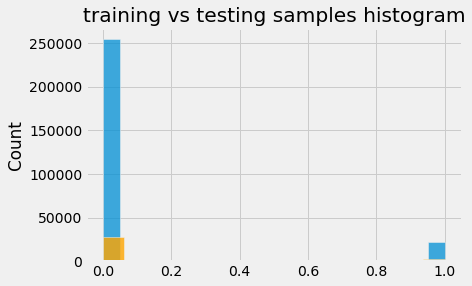

In [74]:
plt.title("training vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:38:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on regular data
[+] accuracy : 0.919872524470749
[+] f1 score : 0.07853403141361257


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


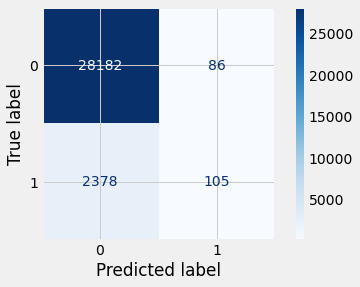

In [86]:
model_xgboost(X_train, y_train)

<AxesSubplot:title={'center':'training vs oversampled vs testing samples histogram'}, ylabel='Count'>

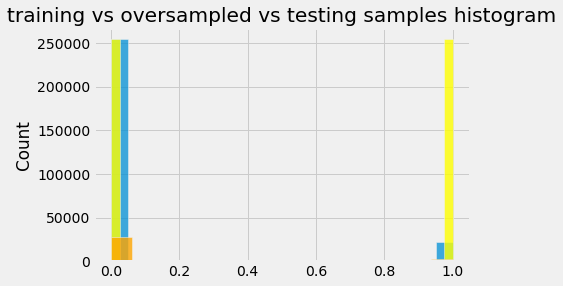

In [75]:
oversample = SMOTE()
X_trainO, y_trainO = oversample.fit_resample(X_train, y_train)

# histogram of the train vs train_oversample vs test data
plt.title("training vs oversampled vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_train0.values, color="yellow", alpha=.8)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:39:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on regular data
[+] accuracy : 0.9189945042437644
[+] f1 score : 0.07225325884543761


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


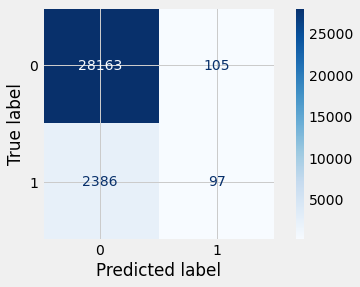

In [87]:
model_xgboost(X_trainO, y_trainO)

In [113]:
undersample = NearMiss(version=1, n_neighbors=3, sampling_strategy=0.5)
oversample = RandomOverSampler(sampling_strategy='minority')
X, y = undersample.fit_resample(X, y)
X_over, y_over = oversample.fit_resample(X, y)

<AxesSubplot:title={'center':'training vs testing samples histogram'}, ylabel='Count'>

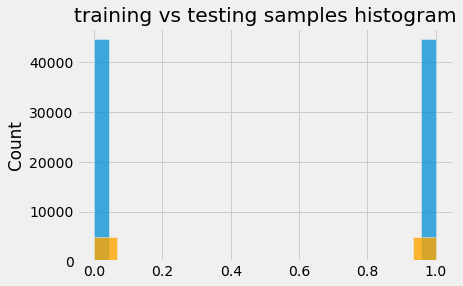

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.1, random_state=42, stratify=y_over)

plt.title("training vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on regular data
[+] accuracy : 0.8500503524672709
[+] f1 score : 0.8441979700742911


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


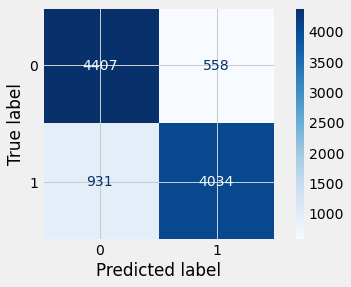

In [115]:
model_xgboost(X_train, y_train)

<AxesSubplot:title={'center':'training vs oversampled vs testing samples histogram'}, ylabel='Count'>

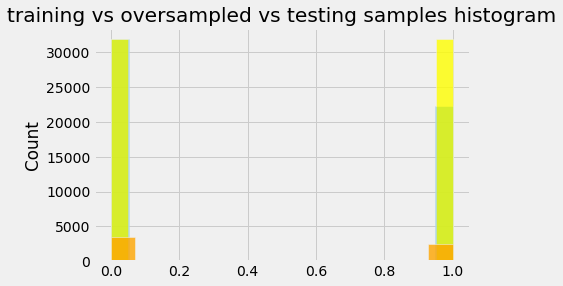

In [103]:
oversample = SMOTE()
X_trainO, y_trainO = oversample.fit_resample(X_train, y_train)

# histogram of the train vs train_oversample vs test data
plt.title("training vs oversampled vs testing samples histogram")
sns.histplot(y_train.values)
sns.histplot(y_trainO.values, color="yellow", alpha=.8)
sns.histplot(y_test.values, color="orange", alpha=.8)

C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:03:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[+] training on regular data
[+] accuracy : 0.8736108807430751
[+] f1 score : 0.8365508365508366


C:\Users\letiz\miniconda3\envs\factonics\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


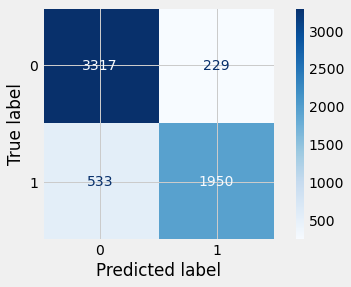

In [104]:
model_xgboost(X_trainO, y_trainO)

In [ ]:
# class Weight 